In [39]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

CPU times: user 721 ms, sys: 588 ms, total: 1.31 s
Wall time: 1.31 s


In [40]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.7 µs


In [41]:
%%time
model = ResNet18()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 32, 32, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 32, 32, 64)   256         conv2d_107[0][0]                 
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 32, 32, 64)   0           batch_normalization_100[0][0]    
____________________________________________________________________________________________

In [42]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 4.22 ms, sys: 3.06 ms, total: 7.28 ms
Wall time: 6.24 ms


In [43]:
%%time
# 학습 루프
history = model.fit(x_train, y_train, batch_size=32, epochs=100)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/100
1563/1563 [==============================] - 63s 39ms/step - loss: 1.2507 - accuracy: 0.5519
Epoch 2/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.7569 - accuracy: 0.7353
Epoch 3/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.5679 - accuracy: 0.8043
Epoch 4/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.4458 - accuracy: 0.8449
Epoch 5/100
1563/1563 [==============================] - 62s 40ms/step - loss: 0.3393 - accuracy: 0.8814
Epoch 6/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.2445 - accuracy: 0.9139
Epoch 7/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.1753 - accuracy: 0.9376
Epoch 8/100
1563/1563 [==============================] - 61s 39ms/step - loss: 0.1263 - accuracy: 0.9547
Epoch 9/100
1563/1563 [==============================] - 62s 40ms/step - loss: 0.0978 - accuracy: 0.9648
Epoch 10/100
1563/1563 [==============================]

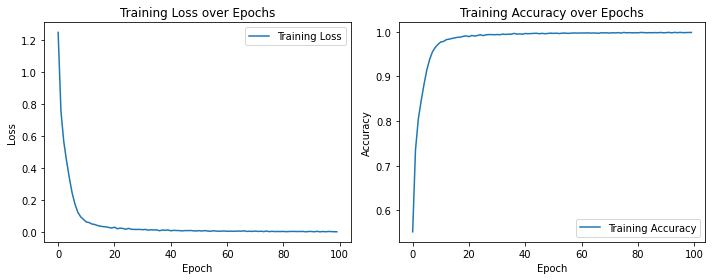

CPU times: user 533 ms, sys: 212 ms, total: 745 ms
Wall time: 385 ms


In [44]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Baseline에 해당되는 진영님이 구현한 ResNet 18 모델에서 Shuffle, 미니배치, 프리페치, 배치 사이즈 증가 등을 통해 
# 연산 속도를 증가 시키는 것을 분석하게 되었음. 
# Baseline 에폭 100회 연산 시간 : 1: 41 : 29
# Train acc : 0.99
# Test acc : 0.85
# Test loss : 1.0745
# Test01를 진행하며 위에 해당하는 값들을 분석해볼 예정